In [2]:
import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import roc_curve
import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
seed = 999 # seed to generate random numbers

# Index
* [Load the data](#Load-the-data)
* [Generate target](#Generate-target)
* [Feature Engineering](#Feature-Engineering)
    * [Dealing previous loan history](#Dealing-previous-loan-history)
    * [Employment information](#Employment-status-and-salary)
    * [One-Hot-Encoding features](#One-Hot-Encoding-purpose)
* [Train the model](#Train-the-model)
* [Choose best probability cutoff](#Choose-best-probablity-cutoff)
* [Re-train the model with all training data](#Re-train-the-model-with-all-training-data)
* [Test](#Test)
* [Feature importance](#Feature-importance)
* [Extra useful features](#Extra-useful-features)
* Answer Questions
    * [Answer question 2](#Test)
    * [Answer question 3](#q3)
    * [Answer question 4](#Extra-useful-features)

## Load the data

In [4]:
loan = pd.read_csv("loan_table.csv",index_col='loan_id')
# rename columns to short name, which is easier to visualize
loan.rename(columns={'loan_purpose':'purpose',
                     'loan_granted':'granted',
                     'loan_repaid':'repaid'},inplace=True)
loan['date'] = pd.to_datetime(loan.date)

In [5]:
borrower = pd.read_csv("borrower_table.csv",index_col='loan_id')
# rename columns to short name, which is easier to visualize
borrower.rename(columns={'is_first_loan':'is_first',
                         'fully_repaid_previous_loans':'repay_prev',
                         'currently_repaying_other_loans':'paying_others',
                         'total_credit_card_limit':'credit_limit',
                         'avg_percentage_credit_card_limit_used_last_year':'credit_used',
                         'saving_amount':'saving',
                         'checking_amount':'checking',
                         'yearly_salary':'salary',
                         'dependent_number':'n_depends'},inplace=True)

In [6]:
# merge loan information and borrow information together
loan = borrower.join(loan)

In [7]:
loan.sample(5)# get a feeling about the data

,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,is_employed,salary,age,n_depends,purpose,date,granted,repaid
loan_id,,,,,,,,,,,,,,,
773800,0,1.0,0.0,5000,0.74,1467,1946,0,0,55,1,home,2012-04-09,0,NaN
420677,1,NaN,NaN,7500,0.71,2625,6144,1,39900,35,6,home,2012-02-15,1,1.0
23056,0,1.0,0.0,0,NaN,850,2820,1,17100,30,3,emergency_funds,2012-02-21,0,NaN
964618,0,1.0,0.0,4800,0.56,4477,1395,0,0,33,8,emergency_funds,2012-07-16,0,NaN
528958,1,NaN,NaN,3300,0.61,1662,2216,1,10400,29,3,emergency_funds,2012-10-30,1,0.0


## Generate target

In [8]:
def calc_profit_and_should_grant(row):
    """
    generate 'profit' and 'should_grant' target column according to rule:
    1. if not granted, profit=0, should_grant=0
    2. if granted and repaid, profit=1, should_grant=1
    3. if granted and not repaid, profit=-1, should_grant=0
    """
    granted = row['granted']
    repaid = row['repaid']

    profit = 0
    should_grant = 0

    if granted == 0:
        profit = 0
        should_grant = 0
    else: # granted == 1
        assert pd.notnull(repaid)
        profit = 1 if repaid == 1 else -1
        should_grant = 1 if repaid == 1 else 0

    return pd.Series({'profit':profit,'should_grant':should_grant})

In [9]:
profits = loan.apply(calc_profit_and_should_grant,axis=1)

In [10]:
loan = loan.join(profits)# merget together

In [11]:
loan.sample(5)# browse the data, get a feeling about the data

,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,is_employed,salary,age,n_depends,purpose,date,granted,repaid,profit,should_grant
loan_id,,,,,,,,,,,,,,,,,
319226,1,NaN,NaN,3700,0.98,534,2428,0,0,23,7,home,2012-11-06,0,NaN,0,0
856836,1,NaN,NaN,6000,0.39,2016,2517,1,21500,33,2,investment,2012-09-07,1,1.0,1,1
764012,1,NaN,NaN,1700,0.74,1110,2267,1,28500,67,3,home,2012-04-09,1,0.0,-1,0
829531,0,0.0,0.0,2000,0.77,1137,1190,0,0,25,2,business,2012-11-20,0,NaN,0,0
217901,0,1.0,0.0,2500,0.96,1155,1797,0,0,33,1,home,2012-08-27,0,NaN,0,0


## Feature Engineering

In [12]:
X = loan.copy()

### Dealing previous loan history
there is some redundacy between 'is_first', 'repay_prev' and 'paying_other' features. if 'is_first'==1, then 'repay_prev' and 'paying_others' are both NaN for sure. 

since I am going to use tree model, which is good at dealing with 'categorical feature', so I will treat the tree features like below:
1. set 'NaN' in 'reay_prev' and 'paying_others' as -1, which indicates the brower is asking for loan the first time
2. discard 'is_first' feature, since its information has already been included in '-1' in 'repay_prev' and 'paying_others'

in other words, <span style='color:orange;font-size:1.5em'>I treat 'repay_others' and 'paying_others' as categorical feature, and just use ordinary Ordinal Encoding other than more-often used One-Hot-Encoding</span>. why? because ** tree model looks for cutoff in numeric feature other than calculating the distance **, and there is only 3 unique values in the feature (-1,0,1), which is very easy to find cutoff to distinguish each category.

In [13]:
X.fillna({'repay_prev':-1,'paying_others':-1},inplace=True)
del X['is_first'] # redundant after filling missing in 'repay_prev' and 'paying_others'

### Employment status and salary

In [14]:
X.loc[X.is_employed==0,'salary'].value_counts()

0    34508
Name: salary, dtype: int64

In [15]:
X.loc[X.salary==0,'is_employed'].value_counts()

0    34508
1       13
Name: is_employed, dtype: int64

from above result, we can know that:
1. all unemployed has 0 salary
2. most of the brower who doesn't have salary are unemployed

<span style='color:orange;font-size:1.5em'>so there is redundancy between 'is_employed' and 'salary ==0 or not'. more features, more easier to get over-fitting. so I keep 'salary' and decide to drop 'is_employed'</span>

In [16]:
# redudant, since 'not employed' has salary=0
# and, most employed has salary>0
del X['is_employed'] 

### One-Hot-Encoding purpose

since I am going to use train model, which can accept Ordinal Encoding of the categorical feature. However, since 'purpose' has 5 unique values, I think OHE can reduce the burden of tree.

In [17]:
X.purpose.value_counts()

home               24314
business           21707
investment         21484
emergency_funds    18091
other              15504
Name: purpose, dtype: int64

In [18]:
# since 'purpose' is the only text column, get_dummies only OHE 'purpose'
X = pd.get_dummies(X)

# K unique values, only need K-1 features, so remove one redundant feature
del X['purpose_other'] # redudant

# rename to short names, which is easier to read
X.rename(columns={'purpose_emergency_funds':'purpose_emergency'},inplace=True)

In [19]:
X.sample(5)# check the data

,repay_prev,paying_others,credit_limit,credit_used,saving,checking,salary,age,n_depends,date,granted,repaid,profit,should_grant,purpose_business,purpose_emergency,purpose_home,purpose_investment
loan_id,,,,,,,,,,,,,,,,,,
762323,1.0,0.0,4700,0.56,2483,6679,0,69,0,2012-08-28,0,NaN,0,0,1,0,0,0
982167,-1.0,-1.0,900,0.96,710,1619,28600,50,6,2012-07-31,1,0.0,-1,0,0,1,0,0
696956,-1.0,-1.0,4000,0.76,3567,3188,30800,25,8,2012-03-29,1,1.0,1,1,1,0,0,0
987111,-1.0,-1.0,4800,1.05,738,2643,0,25,1,2012-11-30,0,NaN,0,0,0,0,1,0
819436,-1.0,-1.0,5400,0.81,1059,918,14200,48,3,2012-09-05,1,0.0,-1,0,0,0,1,0


In [20]:
X.to_csv("cleaned_loan.csv",index_label='loan_id')

## Train the model

In [21]:
y = X.loc[:,'should_grant']

feature_names = ['repay_prev', 'paying_others', 'credit_limit', 'credit_used',
                 'saving', 'checking', 'salary', 'age', 'n_depends', 
                 'purpose_business','purpose_emergency', 'purpose_home', 'purpose_investment']
X = X.loc[:,feature_names]

In [22]:
y.value_counts(normalize=True)

0    0.696281
1    0.303719
Name: should_grant, dtype: float64

positive class 'should_grant=1' consists of about 30% of all examples, there is some imbalance in the dataset. so 
* ** we should use AUC other than accuracy when learning the model, and **
* ** we need to choose a better 'probability cutoff' instead of using the default 0.5 **

split the whole dataset into Training, Validation, Test three parts, and build DMatrix which will be used in xgboost

In [23]:
# split as training and test
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=seed)

# split the training data as training and test
Xtrain,Xvalid,ytrain,yvalid =  train_test_split(Xtrain,ytrain,test_size=0.3,random_state=seed)

In [27]:
train_matrix = xgb.DMatrix(Xtrain,ytrain)
valid_matrix = xgb.DMatrix(Xvalid,yvalid)
test_matrix = xgb.DMatrix(Xtest,ytest)

In [28]:
def train(params):
    params['silent'] = 1
    params['objective'] = 'binary:logistic'  # output probabilities
    params['eval_metric'] = 'auc'

    num_rounds = params["num_rounds"]
    early_stopping_rounds = params["early_stop_rounds"]

    # early stop will check on the last dataset
    watchlist = [(train_matrix, 'train'), (valid_matrix, 'validate')]
    bst = xgb.train(params, train_matrix, num_rounds, watchlist, early_stopping_rounds=early_stopping_rounds)

    print( "parameters: {}".format(params))
    print( "best {}: {:.2f}".format(params["eval_metric"], bst.best_score))
    print( "best #trees: %d" % (bst.best_ntree_limit))

    return bst

In [29]:
# ------------- prepare parameters
params = {}
params["num_rounds"] = 300
params["early_stop_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

# ------------- train with xgboost
bst = train(params)

[0]	train-auc:0.888739	validate-auc:0.886229
Multiple eval metrics have been passed: 'validate-auc' will be used for early stopping.

Will train until validate-auc hasn't improved in 30 rounds.
[1]	train-auc:0.888199	validate-auc:0.887179
[2]	train-auc:0.890342	validate-auc:0.889529
[3]	train-auc:0.893875	validate-auc:0.891527
[4]	train-auc:0.896326	validate-auc:0.893274
[5]	train-auc:0.896324	validate-auc:0.894179
[6]	train-auc:0.897659	validate-auc:0.895089
[7]	train-auc:0.898168	validate-auc:0.894464
[8]	train-auc:0.898668	validate-auc:0.895054
[9]	train-auc:0.898986	validate-auc:0.894748
[10]	train-auc:0.899547	validate-auc:0.895002
[11]	train-auc:0.899851	validate-auc:0.894446
[12]	train-auc:0.899856	validate-auc:0.893932
[13]	train-auc:0.899969	validate-auc:0.893319
[14]	train-auc:0.900951	validate-auc:0.894116
[15]	train-auc:0.901471	validate-auc:0.894605
[16]	train-auc:0.902092	validate-auc:0.895134
[17]	train-auc:0.902534	validate-auc:0.895262
[18]	train-auc:0.902977	validate-

In [30]:
n_trees = bst.best_ntree_limit
n_trees

81

## Choose best probablity cutoff

I am going to find best 'probability cutoff' on validation set's ROC curve.

In [31]:
yvalid_true = valid_matrix.get_label()
yvalid_pred_probas = bst.predict(valid_matrix, ntree_limit=bst.best_ntree_limit)

fpr,tpr,thresholds = roc_curve(yvalid_true,yvalid_pred_probas)
roc = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})

I am going to loop every possible threshold, and find the one which returns the highest profit.

In [34]:
def calc_profits(repaids,probas,threshold):
    total_profit = 0
    for (repaid,proba) in zip(repaids,probas):
        if proba > threshold:
            # it is possible for repaid=NaN
            # which means, my model grant loan to a borrower whose application was rejected under old model
            # the question doesn't clarify how to calculate profit for such case.
            # however, since most 'rejected borrowers' were considered unlikely to repay by old model
            # so I also think such people are very unlikely to repay even were granted
            # so their profit are also -1, the same as 'granted but unable to repay'
            total_profit += (1 if repaid == 1 else -1)
    return total_profit

In [35]:
# all examples in validation sets
loan_valid = loan.loc[yvalid.index,:]

# calculate profits under each candidate cutoff
valid_profits = [ calc_profits(loan_valid.repaid,yvalid_pred_probas,threshold) for threshold in roc.Thresholds]

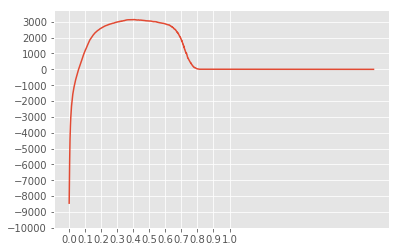

In [37]:
plt.plot(roc.Thresholds,valid_profits)
plt.yticks(range(-10000,4000,1000))
_ = plt.xticks(np.linspace(0,1,11))
plt.rc('figure',figsize=(5,5))

from above plot, we know that, the best probability cutoff should be around 0.4, which can proved by following codes

In [39]:
valid_threshold_profits = pd.DataFrame({'threshold':roc.Thresholds,'profit':valid_profits})
temp = valid_threshold_profits.loc[  valid_threshold_profits.profit.idxmax()   ,:]
temp

profit       3143.000000
threshold       0.404506
Name: 3411, dtype: float64

In [40]:
proba_threshold = temp['threshold']
proba_threshold

0.4045059084892273

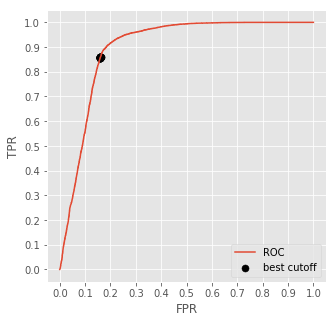

In [41]:
# plot ROC
plt.plot(roc.FPR,roc.TPR,label='ROC')
plt.xlabel("FPR")
plt.ylabel('TPR')

ticks = np.linspace(0,1,11)
plt.yticks(ticks)
plt.xticks(ticks)

# plot best thresholds
best_cutoffs = roc.loc[ (roc.Thresholds > 0.43) & (roc.Thresholds < 0.44),:]
plt.scatter(best_cutoffs.FPR,best_cutoffs.TPR,c='k',s=50,label='best cutoff')

plt.rc('figure',figsize=(10,5))
plt.legend(loc='best')

## Re-train the model with all training data

combine training data and validation set together, train with the best parameters found. this can improve the model.

In [42]:
# combine training set and validation set together
Xalltrain = pd.concat([Xtrain,Xvalid],axis=0)
yalltrain = pd.concat([ytrain,yvalid],axis=0)
alltrain_matrix = xgb.DMatrix(Xalltrain,yalltrain)

In [43]:
# check the parameters
params

{'colsample_bytree': 0.8,
 'early_stop_rounds': 30,
 'eta': 0.1,
 'eval_metric': 'auc',
 'max_depth': 6,
 'num_rounds': 300,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.8}

In [44]:
# best number of trees
n_trees

81

In [45]:
watchlist = [(alltrain_matrix, 'train')]
all_bst = xgb.train(params, alltrain_matrix, n_trees,watchlist)

[0]	train-auc:0.888382
[1]	train-auc:0.88946
[2]	train-auc:0.894307
[3]	train-auc:0.895248
[4]	train-auc:0.897195
[5]	train-auc:0.898178
[6]	train-auc:0.898439
[7]	train-auc:0.89882
[8]	train-auc:0.898823
[9]	train-auc:0.898845
[10]	train-auc:0.899069
[11]	train-auc:0.899075
[12]	train-auc:0.899502
[13]	train-auc:0.899817
[14]	train-auc:0.899853
[15]	train-auc:0.900579
[16]	train-auc:0.900807
[17]	train-auc:0.900849
[18]	train-auc:0.900973
[19]	train-auc:0.90137
[20]	train-auc:0.901663
[21]	train-auc:0.901912
[22]	train-auc:0.90203
[23]	train-auc:0.902079
[24]	train-auc:0.90234
[25]	train-auc:0.902528
[26]	train-auc:0.902644
[27]	train-auc:0.902743
[28]	train-auc:0.902737
[29]	train-auc:0.903119
[30]	train-auc:0.90355
[31]	train-auc:0.903989
[32]	train-auc:0.904154
[33]	train-auc:0.904345
[34]	train-auc:0.904467
[35]	train-auc:0.904726
[36]	train-auc:0.905022
[37]	train-auc:0.905198
[38]	train-auc:0.905419
[39]	train-auc:0.905752
[40]	train-auc:0.906099
[41]	train-auc:0.90624
[42]	trai

## Test

In [46]:
ytest_pred_probas = all_bst.predict(test_matrix, ntree_limit=n_trees)
ytest_pred = (ytest_pred_probas > proba_threshold).astype(int)

In [48]:
print( "test accuracy: ",accuracy_score(ytest,ytest_pred))

test accuracy:  0.8434882954170788


In [49]:
print( classification_report(ytest,ytest_pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88     21161
           1       0.69      0.88      0.77      9169

   micro avg       0.84      0.84      0.84     30330
   macro avg       0.81      0.85      0.83     30330
weighted avg       0.86      0.84      0.85     30330



In [50]:
# profit under old model
loan_test = loan.loc[ytest.index,:]
old_profit = loan_test.profit.sum()
old_profit

4130

In [51]:
# profit under new model
new_profit = calc_profits(loan_test.repaid,ytest_pred_probas,proba_threshold)
new_profit

4422

from above result, <span style='color:orange;font-weight:bold;font-size:1.5em'>the model yields a profit as 4130, while my new model can yield a profit as 4400, improved 6.5%.</span>

## Feature importance

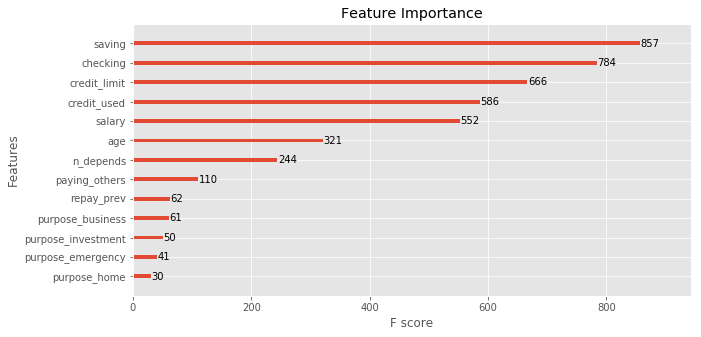

In [52]:
xgb.plot_importance(all_bst,title='Feature Importance')

<a id='q3'></a>** Answer Question 3 **, *"Describe the impact of the most important variables on the prediction. Also, focus on the variable "is_employed", which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model? Explain why"*

according to above plot, the most important feature is 'saving amount'. This makes perfect sense. Money in the saving account, meaure a person's ability to control his financial situation. More money in the saving account, more likely the borrower can repay.

as I mentioned, in my model, 'is_employed' is merged into feature 'salary', which correspond to the case 'salary=0'. according to above plot, salary is also a strong feature. 
* if not employed, then salary=0, which will impact negatively on 'grant decision'. that is very easy to understand, a person without any financial input, will be very unlikely to repay.
* but even the person is employed, whether grant the loan or not, depends on his salary. higher salary indicates strong ability to repay.

## Extra useful features
** Answer Question 4: ** * "Are there any other variables, not in the data provided, that you'd have liked to include in the model?" *

some useful feature which may include:
1. marriage status. 
    * Because even a borrow cannot repay, if he/she is married, his/her spouse can help to repay.
2. housing status, has his/her own house, or rent appartments? if renting, how much is monthly rent?
    * Because even the borrower cannot repay, if he/she has house, the house can be sold to repay the debt
3. educational level
    * normally a person who received higher education, has stronger capability to earn money to repay, and has higher moral standard to repay.